# **1. Introduction**


This project uses the `stroke-data.csv` dataset from Kaggle to build a machine learning model that predicts a patient's risk of stroke. Due to the rarity of stroke cases, we address class imbalance and focus on metrics like **Recall** and **ROC-AUC** to avoid missing high-risk patients.

Key steps:
- Data cleaning and feature selection
- Model testing and evaluation
- Emphasis on accuracy and clinical usefulness

The goal is a reliable, easy-to-use tool to help doctors detect stroke risk early.

In [1]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# **2. Data Overview** (EDA)

In this section, we load the dataset, inspect its structure, and provide an initial understanding of the available features.

In [2]:
import pandas as pd

# Loading the dataset
data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# Displaying the first five rows
data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Dataset Description**

The dataset contains 5110 patient records and 12 columns, including information about demographics, medical history, and stroke occurrence.
Each column is described below:

| Column Name | Description |
|:---|:---|
| **id** | Unique identifier for each patient |
| **gender** | Gender of the patient (Male, Female, Other) |
| **age** | Age of the patient (numeric) |
| **hypertension** | 0 = No hypertension, 1 = Has hypertension |
| **heart_disease** | 0 = No heart disease, 1 = Has heart disease |
| **ever_married** | Yes or No |
| **work_type** | Type of work: children, Govt_job, Never_worked, Private, Self-employed |
| **Residence_type** | Urban or Rural |
| **avg_glucose_level** | Average glucose level in blood (numeric) |
| **bmi** | Body Mass Index (numeric) |
| **smoking_status** | formerly smoked, never smoked, smokes, or Unknown |
| **stroke** | 0 = No stroke, 1 = Stroke occurred |

**Initial Data Summary**

In [3]:
# Checking for missing values
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
# Checking the distribution of the target variable
data['stroke'].value_counts(normalize=True)

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

**Findings,**

1. Some missing values exist, especially in the **BMI column**.

2. The **"smoking_status"** column includes an **"Unknown" category**, which will need special handling.

3. The dataset is highly **imbalanced**, with only about **5%** of patients having had a stroke.

# **3. Data Cleaning**

In this section, we address missing values and prepare the dataset for further analysis.

**Handling Missing Values**

In [5]:
# Imputing median by age group
data['bmi'] = data['bmi'].fillna(data.groupby('age')['bmi'].transform('median'))

# Removing rows where smoking_status is "Unknown"
data = data[data['smoking_status'] != 'Unknown']

data.shape

(3566, 12)

In [6]:
# Checking again for missing values
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
# Checking the stroke distribution again
data['stroke'].value_counts(normalize=True)

stroke
0    0.943354
1    0.056646
Name: proportion, dtype: float64

**Findings:**

The class imbalance remains; strokes still account for a small minority of cases (~5%), which we will address later during model training.

# **4. Feature Selection**

In this section, we select the most relevant features for stroke prediction based on medical research and domain knowledge.

**Choosing Relevant Features**

Following guidance from the medical team and supported by **(Stroke risk factors and prevention, n.d.)**, the following features are known to have a significant impact on stroke risk:

| Feature | Reason for Selection |
|:---|:---|
| **age** | Stroke risk increases significantly with age. |
| **hypertension** | High blood pressure is a leading risk factor for stroke. |
| **heart_disease** | Existing heart conditions are linked to higher stroke risk. |
| **avg_glucose_level** | Elevated glucose levels can indicate diabetes, increasing stroke risk. |
| **bmi** | Obesity is a major stroke risk factor. |
| **smoking_status** | Smoking significantly raises the risk of stroke. |
| **gender** | Some studies show gender-based differences in stroke incidence. |

However, we would like to ensure that our feature selection is accurate, by some visuals

In [8]:
selected_features = ['gender', 'age', 'hypertension', 'heart_disease', 
                    'avg_glucose_level', 
                     'bmi', 'smoking_status', 'stroke']

# Creating a new DataFrame with only the selected features
data_selected = data[selected_features]

# Displaying the first few rows
data_selected.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,202.21,29.45,never smoked,1
2,Male,80.0,0,1,105.92,32.50,never smoked,1
3,Female,49.0,0,0,171.23,34.40,smokes,1
4,Female,79.0,1,0,174.12,24.00,never smoked,1


**Visual Support for Feature Selection (EDA)**

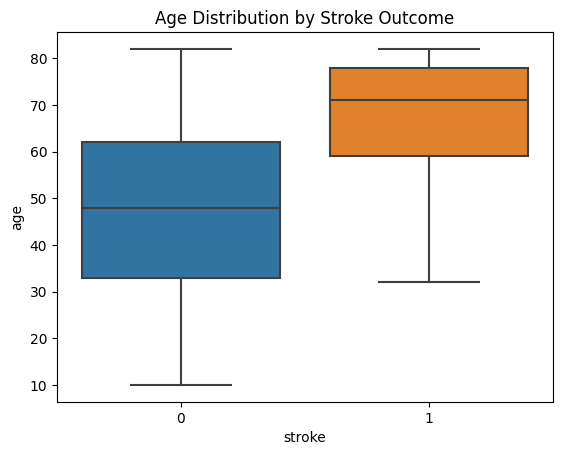

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='stroke', y='age', data=data_selected)
plt.title('Age Distribution by Stroke Outcome')
plt.show()

The boxplot shows that **age** strongly separates stroke vs. non-stroke patients: stroke cases have a **median age over 60**, while non-stroke patients are **younger and more varied**. This confirms age as a **key risk factor** and supports its use in our model.

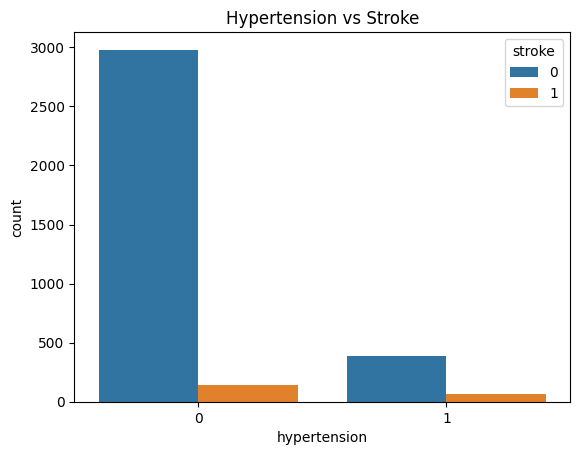

In [10]:
sns.countplot(x='hypertension', hue='stroke', data=data_selected)
plt.title('Hypertension vs Stroke')
plt.show()

The countplot shows that **hypertensive patients have a higher stroke rate**: even though there are fewer of them overall, a larger share of hypertensive individuals experienced strokes compared to those without hypertension. This confirms hypertension as a **key modifiable risk factor** and supports its inclusion in our model.

# **5. Feature Engineering**

We engineered features to boost model performance and reflect clinical practice by converting continuous variables into meaningful categories, simplifying complex features, and creating new interaction variables.

**5.1 Categorizing Age**

Medical literature suggests age-related stroke risk increases sharply in later life, as learnt from **(Park *et al.,* 2013)**. To better capture this pattern, we grouped patients into clinically relevant age bands, using the age ranges reported in the research by **(Yao *et al.,* 2012)**.

In [11]:
data_selected = data_selected.copy()

def categorize_age(age):
    if age < 50:
        return 'young_adult'
    elif 50 <= age <= 80:
        return 'middle_aged'
    else:
        return 'very_old'

data_selected['age_group'] = data_selected['age'].apply(categorize_age)

 **5.2 Categorizing BMI & Glucose**
 
We learned from **Centers for Disease Control and Prevention, 2024** that BMI and glucose are continuous variables with medically defined thresholds that indicate risk groups. Therefore, we transformed these variables into standard categories.

In [12]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'bmi_0_underweight'
    elif 18.5 <= bmi < 25:
        return 'bmi_1_healthy'
    elif 25 <= bmi < 30:
        return 'bmi_2_overweight'
    elif 30 <= bmi < 35:
        return 'bmi_3_obesity_class_1'
    elif 35 <= bmi < 40:
        return 'bmi_4_obesity_class_2'
    else:
        return 'bmi_5_obesity_class_3'

data_selected['bmi_category'] = data_selected['bmi'].apply(categorize_bmi)

In [13]:
import numpy as np 

def glucose_category(glucose):
    if glucose < 70:
        return 'glucose_0_<70'
    elif 70 <= glucose <= 84:
        return 'glucose_1_70_84'
    elif 85 <= glucose <= 99:
        return 'glucose_2_85_99'
    elif 100 <= glucose <= 109:
        return 'glucose_3_100_109'
    elif 110 <= glucose <= 125:
        return 'glucose_4_110_125'
    elif 126 <= glucose <= 139:
        return 'glucose_5_126_139'
    else:
        return 'glucose_6_140_plus'

# Applying glucose category
data_selected['glucose_category'] = data_selected['avg_glucose_level'].apply(glucose_category)
# Dropping the original column once
data_selected.drop('avg_glucose_level', axis=1, inplace=True)

 **5.3 Binary Smoking Status**

To reduce complexity and highlight overall exposure, this is the ordinal encode of smoking status

In [14]:
smoking_mapping = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2
}
data_selected['smoking_status_encoded'] = data_selected['smoking_status'].map(smoking_mapping)

**5.4 Creating Risk Indicators & Interactions**

We created new features that combines hypertension with heart disease and age status into seperate risk indicators and encoded glucose and BMI categories numerically, created interaction features (glucose × age, glucose × BMI), and added binary flags (`is_elderly`, `is_obese`, `high_glucose`) to highlight key stroke risk patterns.


In [15]:
data_selected['health_risk'] = data_selected['hypertension'] + data_selected['heart_disease']
# 0 = no risk, 1 = moderate risk, 2 = high risk

In [16]:
data_selected['lifestyle_risk'] = data_selected['smoking_status_encoded'] + data_selected['health_risk']

In [17]:
data_selected['total_risk'] = data_selected['health_risk'] + data_selected['lifestyle_risk']

In [18]:
glucose_mapping = {
    'glucose_0_<70': 0,
    'glucose_1_70_84': 1,
    'glucose_2_85_99': 2, 
    'glucose_3_100_109': 3,
    'glucose_4_110_125': 4,
    'glucose_5_126_139': 5,
    'glucose_6_140_plus': 6
}

data_selected['glucose_category_encoded'] = data_selected['glucose_category'].map(glucose_mapping)

In [19]:
bmi_mapping = {
    'bmi_0_underweight': 0,
    'bmi_1_healthy': 1,
    'bmi_2_overweight': 2,
    'bmi_3_obesity_class_1': 3,
    'bmi_4_obesity_class_2': 4,
    'bmi_5_obesity_class_3': 5
}

data_selected['bmi_category_encoded'] = data_selected['bmi_category'].map(bmi_mapping)

In [20]:
data_selected['age_glucose_interaction'] = data_selected['glucose_category_encoded'] * data_selected['age']
data_selected['bmi_glucose_interaction'] = data_selected['glucose_category_encoded'] * data_selected['bmi_category_encoded']

In [21]:
data_selected['is_elderly'] = (data_selected['age'] > 80).astype(int)
data_selected['is_obese'] = data_selected['bmi_category'].str.contains('obesity').astype(int)
data_selected['high_glucose'] = data_selected['glucose_category'].str.contains('140').astype(int)

**5.5 Encoding Categorical Variables**

To prepare the dataset for machine learning, all categorical features were encoded using one-hot encoding:

In [22]:
# Encoding selected categorical variables
categorical_features = [
    'gender',
    'age_group',
    'glucose_category',
    'bmi_category',
    'smoking_status'
]

data_encoded = pd.get_dummies(data_selected, columns=categorical_features, drop_first=True)

data_encoded.head()

,age,hypertension,heart_disease,bmi,stroke,smoking_status_encoded,health_risk,lifestyle_risk,total_risk,glucose_category_encoded,...,glucose_category_glucose_4_110_125,glucose_category_glucose_5_126_139,glucose_category_glucose_6_140_plus,bmi_category_bmi_1_healthy,bmi_category_bmi_2_overweight,bmi_category_bmi_3_obesity_class_1,bmi_category_bmi_4_obesity_class_2,bmi_category_bmi_5_obesity_class_3,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,36.60,1,1,1,2,3,6,...,False,False,True,False,False,False,True,False,False,False
1,61.0,0,0,29.45,1,0,0,0,0,6,...,False,False,True,False,True,False,False,False,True,False
2,80.0,0,1,32.50,1,0,1,1,2,3,...,False,False,False,False,False,True,False,False,True,False
3,49.0,0,0,34.40,1,2,0,2,2,6,...,False,False,True,False,False,True,False,False,False,True
4,79.0,1,0,24.00,1,0,1,1,2,6,...,False,False,True,True,False,False,False,False,True,False


# **6. Data Preprocessing**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Defining features and target
X = data_encoded.drop(columns=['stroke'])
y = data_encoded['stroke']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **7. Handling Class Imbalance**

In this section, as discussed by **He *et al.,* 2009**, imbalanced datasets require techniques like resampling to avoid bias toward the majority class. So, we address the issue of class imbalance, and since stroke cases are rare in the dataset, the model may become biased toward predicting the majority class (no stroke).
To overcome this, we use **SMOTE (Synthetic Minority Oversampling Technique)** to balance the training data by generating synthetic examples of the minority class.

In [24]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [25]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))

Before SMOTE: Counter({0: 2690, 1: 162})
After SMOTE: Counter({0: 2690, 1: 2690})


# **8. Model Training**

Now that the data is balanced and preprocessed, we can train machine learning models. We will start with **Logistic Regression**, a widely used linear classification algorithm.

We selected multiple models because research shows that **ensemble methods**, such as **Random Forest** ,**Gradient Boosting**, have demonstrated robust performance in imbalanced classification tasks **(Dong et al., 2020)**.

We used **SelectKBest with ANOVA F-statistics** to select the top 10 most predictive features from the training data. This helps reduce dimensionality and improve model focus.

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecting top k features based on ANOVA F-statistics
selector = SelectKBest(score_func=f_classif, k=10) 
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_scaled)

# Checking which features were selected
mask = selector.get_support()
selected_features = X.columns[mask]
print("Selected features:", selected_features.tolist())

Selected features: ['age', 'hypertension', 'heart_disease', 'health_risk', 'lifestyle_risk', 'total_risk', 'age_glucose_interaction', 'high_glucose', 'age_group_young_adult', 'glucose_category_glucose_6_140_plus']


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
model_lr = LogisticRegression(class_weight='balanced', random_state=42)
model_lr.fit(X_train_selected, y_train_balanced)

# Random Forest
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train_selected, y_train_balanced)

# Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_selected, y_train_balanced)

# Decision Tree
model_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)
model_dt.fit(X_train_selected, y_train_balanced)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

# **9. Model Evaluation**

In [28]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

def evaluate_model(model, name):
    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(f"\n=== Classification Report for {name} ===")
    print(classification_report(y_test, y_pred, digits=3))

    model_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': roc,
        'True Positives': tp,
        'False Negatives': fn
    })

model_results = []
evaluate_model(model_lr, "Logistic Regression")
evaluate_model(model_rf, "Random Forest")
evaluate_model(model_gb, "Gradient Boosting")
evaluate_model(model_dt, "Decision Tree")


=== Classification Report for Logistic Regression ===
              precision    recall  f1-score   support

           0      0.980     0.737     0.842       674
           1      0.145     0.750     0.243        40

    accuracy                          0.738       714
   macro avg      0.563     0.744     0.542       714
weighted avg      0.933     0.738     0.808       714


=== Classification Report for Random Forest ===
              precision    recall  f1-score   support

           0      0.949     0.939     0.944       674
           1      0.128     0.150     0.138        40

    accuracy                          0.895       714
   macro avg      0.538     0.545     0.541       714
weighted avg      0.903     0.895     0.899       714


=== Classification Report for Gradient Boosting ===
              precision    recall  f1-score   support

           0      0.952     0.890     0.920       674
           1      0.119     0.250     0.161        40

    accuracy             

In [29]:
# Summarize results
results_df = pd.DataFrame(model_results)

performance_metrics = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']]
error_analysis = results_df[['Model', 'True Positives', 'False Negatives']]

print("\n=== Model Performance Metrics ===\n")
print(performance_metrics.round(3).to_string(index=False))

print("\n=== Error Analysis by Model ===\n")
print(error_analysis.to_string(index=False))


=== Model Performance Metrics ===

              Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression     0.738      0.145    0.75     0.243    0.839
      Random Forest     0.895      0.128    0.15     0.138    0.718
  Gradient Boosting     0.854      0.119    0.25     0.161    0.771
      Decision Tree     0.710      0.119    0.65     0.201    0.780

=== Error Analysis by Model ===

              Model  True Positives  False Negatives
Logistic Regression              30               10
      Random Forest               6               34
  Gradient Boosting              10               30
      Decision Tree              26               14


# **10. Results Discussion**

In this section, we compare and interpret the performance of the trained models, using **Recall and ROC-AUC**.

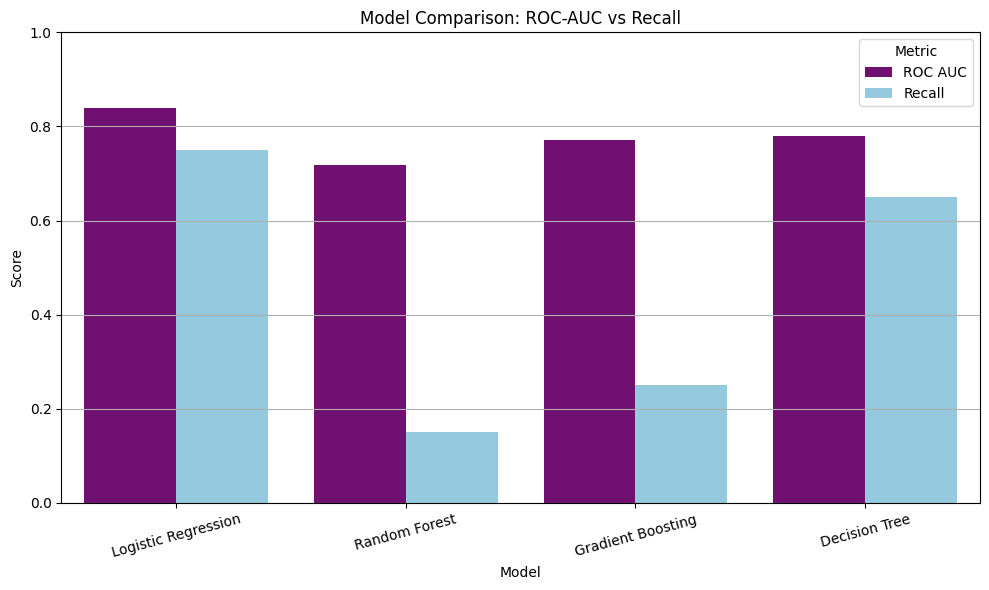

In [30]:
import seaborn as sns
# Reshaping the DataFrame
melted = results_df.melt(id_vars='Model', value_vars=['ROC AUC', 'Recall'], 
                         var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Model', y='Score', hue='Metric', palette=['purple', 'skyblue'])
plt.title('Model Comparison: ROC-AUC vs Recall')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Model Performance Summary

| Metric              | Logistic Regression | Random Forest | Gradient Boosting | Decision Tree |
|---------------------|---------------------|---------------|-------------------|---------------|
| **Recall**          | **0.750 (high)**    | 0.150         | 0.250             | 0.650         |
| **Precision**       | 0.145               | 0.128         | 0.119             | 0.119         |
| **Accuracy**        | 0.738               | **0.895**     | 0.854             | 0.710         |
| **ROC-AUC**         | **0.839 (highest)** | 0.718         | 0.771             | 0.780         |

**Model Trade-offs and Clinical Relevance**

Logistic Regression achieved the highest **ROC-AUC (0.839)** and strong **recall (0.75)**, making it effective at identifying stroke cases. Although its **precision (0.145)** is low, this is acceptable in clinical contexts where missing a true case is more harmful than a false alarm.

While **Random Forest** and **Gradient Boosting** achieved higher accuracy, they had much lower recall, missing many true stroke cases. **Decision Tree** offered a middle ground with balanced recall and acceptable ROC-AUC.

Given the clinical importance of detecting strokes, **Logistic Regression** is the most suitable model when prioritizing patient safety and early intervention.

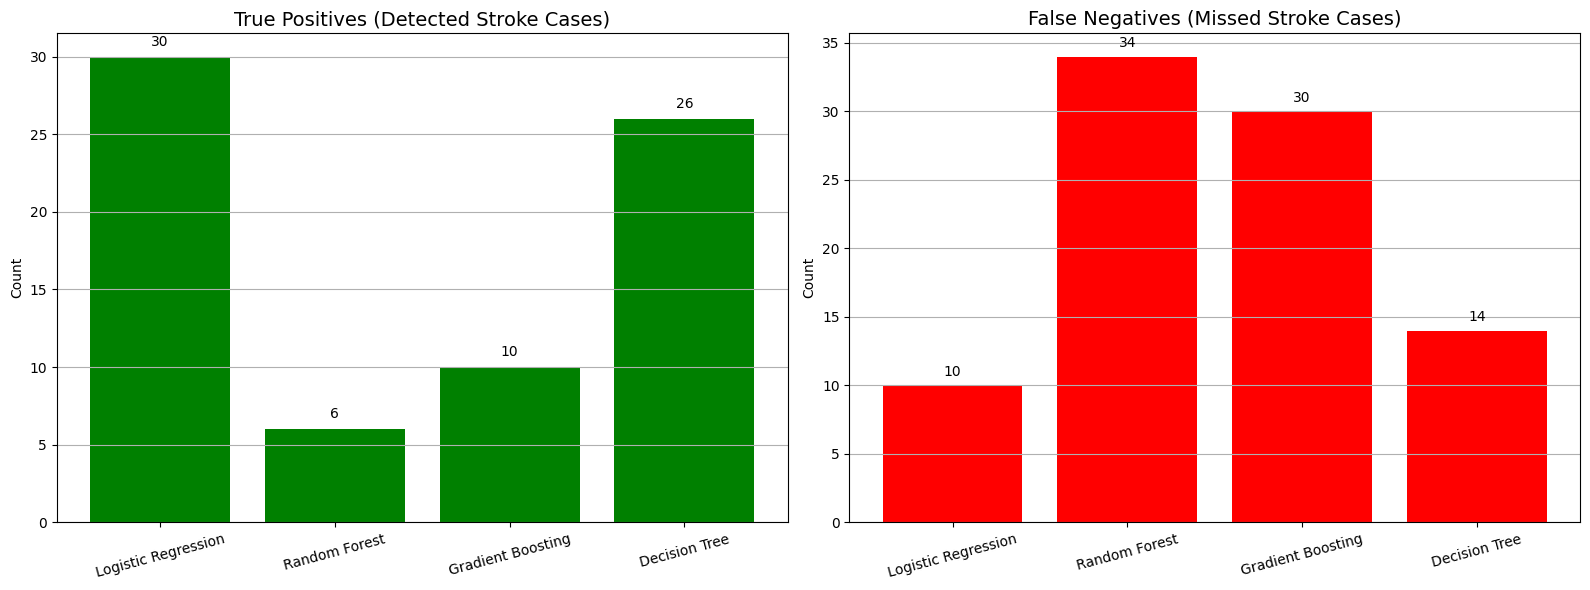

In [31]:
models = results_df['Model']
tp_values = results_df['True Positives']
fn_values = results_df['False Negatives']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True Positives Plot 
axes[0].bar(models, tp_values, color='green')
axes[0].set_title('True Positives (Detected Stroke Cases)', fontsize=14)
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y')

# Annotating TP values
for i, val in enumerate(tp_values):
    axes[0].text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)

# False Negatives Plot
axes[1].bar(models, fn_values, color='red')
axes[1].set_title('False Negatives (Missed Stroke Cases)', fontsize=14)
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y')

# Annotating FN values
for i, val in enumerate(fn_values):
    axes[1].text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

We evaluated four machine learning models based on their ability to correctly detect stroke cases. The focus was on:

- **True Positives**: Correctly identified stroke cases  
- **False Negatives**: Missed stroke cases

These metrics are critical in medical diagnostics, where failing to detect a stroke can have serious consequences. We got, 

| Model               | True Positives | False Negatives |
|--------------------|----------------|-----------------|
| Logistic Regression| **30**         | **10**          |
| Random Forest      | 6              | 34              |
| Gradient Boosting  | 10             | 30              |
| Decision Tree      | 26             | 14              |

### Best Model: Logistic Regression

- Detected the **most stroke cases (30)**
- Missed only **10**, yielding strong recall
- Suitable for **high-sensitivity medical screening**

### Weakest Model: Random Forest

- Detected just **6 stroke cases**
- Missed **34 cases**, the **highest false negative count**
- Not reliable for clinical decision support

**Hyperparameter Tuning in the best model**

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt

# Grid search for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid, cv=5, scoring='recall', n_jobs=-1
)
grid_search.fit(X_train_selected, y_train_balanced)
best_lr_model = grid_search.best_estimator_

# Evaluation
y_pred = best_lr_model.predict(X_test_selected)
y_proba = best_lr_model.predict_proba(X_test_selected)[:, 1]

metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'True Positives': confusion_matrix(y_test, y_pred)[1, 1],
    'False Negatives': confusion_matrix(y_test, y_pred)[1, 0]
}

results_df = pd.DataFrame([metrics])

# Display results
print("=== Model Performance Metrics ===\n")
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].round(3).to_string(index=False))

=== Model Performance Metrics ===

              Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression       0.7      0.134     0.8      0.23    0.841


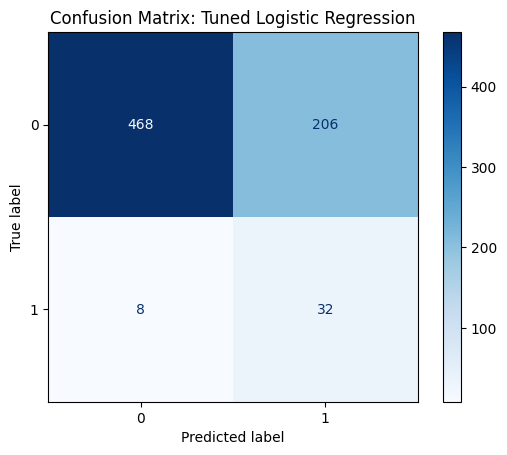

In [33]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix: Tuned Logistic Regression")
plt.show()

**After tuning hyperparameters, Logistic Regression showed improved performance in stroke detection:**

### Model Performance Summary

- **Recall:** 0.80 (high) – correctly identified 32 stroke cases
- **Precision:** 0.134 – low, but acceptable in clinical settings prioritizing safety
- **ROC AUC:** 0.841 – indicates strong overall discrimination ability
- **Accuracy:** 0.70 – moderate overall correctness

---

### Confusion Matrix Analysis

The confusion matrix for the tuned Logistic Regression model shows:

- **True Negatives (TN):** 468  
- **False Positives (FP):** 206  
- **False Negatives (FN):** 8  
- **True Positives (TP):** 32  

The model achieved **high recall 0.80**, with only **8 missed stroke cases**, making it reliable for medical screening where identifying all possible stroke patients is critical. While precision remains low, this is an acceptable trade-off in safety-first applications.

## **11. Conclusion**

### Summary: Stroke Prediction Using Machine Learning

To sum up, we developed a machine learning solution to predict the probability of stroke using patient health records.

**Key Insights**

- **Visual error analysis** (true positives vs. false negatives) helped assess clinical impact of missed stroke cases.
- **Removed weak features** such as `work_type` (low relevance) and `gender=Other` (insufficient data).
- Prioritized **clinical safety** in model selection — **recall was more important than overall accuracy**.

**Performance Highlights**

- The tuned **Logistic Regression** model achieved:
  - **Recall:** 0.80 – correctly identified 32 stroke cases
  - **Precision:** 0.134 – expected trade-off due to prioritizing recall
  - **Accuracy:** 0.70
  - **ROC-AUC:** 0.841 – strong discrimination between stroke and non-stroke cases
- Only **8 stroke cases were missed**, showing strong sensitivity
- Performance reflects realistic and clinically meaningful results on an imbalanced dataset

**Opportunities for Improvement**

- Integrate **richer clinical data** (e.g., lab results, patient history, time-series records)
- Apply **threshold tuning** to better balance sensitivity and specificity (He *et al.*, 2009)
- Explore **advanced ensemble methods** or **AutoML** for optimized and interpretable performance

This solution supports early intervention and risk monitoring, providing valuable decision support in real-world clinical settings.

## **12. References**

- Yao, X., Lin, Y., Geng, J., Sun, Y., Chen, Y., Shi, G., Xu, Q. & Li, Y., 2012. *Age- and gender-specific prevalence of risk factors in patients with first-ever ischemic stroke in China*. Stroke Research and Treatment, \[online] 2012, pp.1–8. Available at: [https://doi.org/10.1155/2012/136398]

- He, H. and Garcia, E.A., 2009. *Learning from imbalanced data*. IEEE Transactions on Knowledge and Data Engineering, 21(9), pp.1263–1284. Available at: [https://ieeexplore.ieee.org/document/5128907]

- Dong, X., Yu, Z., Cao, W., Shi, Y. and Ma, Q., 2020. *A survey on ensemble learning*. Frontiers of Computer Science, 14, pp.241–258. Available at: [https://www.researchgate.net/publication/335504359_A_survey_on_ensemble_learning]

- Hutter, F., Kotthoff, L. and Vanschoren, J., 2019. *Automated machine learning: Methods, systems, challenges*. Springer Nature. Available at: [https://link.springer.com/book/10.1007/978-3-030-05318-5]
 
- Stroke risk factors and prevention, n.d. Better Health Channel. [online] Available at: [https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/stroke-risk-factors-and-prevention]

- Park, C., Guallar, E., Linton, J.A., Lee, D.-C., Jang, Y., Son, D.K., Han, E.-J., Baek, S.J., Yun, Y.D., Jee, S.H. and Samet, J.M., 2013. Fasting glucose level and the risk of incident atherosclerotic cardiovascular diseases. Diabetes Care, 36(7), pp.1988–1993. Available at:[https://pmc.ncbi.nlm.nih.gov/articles/PMC3687304/]

- Centers for Disease Control and Prevention (CDC), 2024. Adult BMI categories. [online]. Available at: [https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html]
